# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

## Шаг 1. Откройте файлы с данными

In [1]:
!pip install -U scikit-learn --upgrade

     |████████████████████████████████| 30.8 MB 45 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import sklearn
sklearn.__version__

'1.1.2'

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV



from sklearn.metrics import f1_score

In [4]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_train.head(2)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2


Импортируем и просматриваем данные Data Frame ("hotel_train")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

Просматриваем всю информацию, а именно кол-во строк, столбцов, типы столбцов, наличите Nan и др.

In [6]:
df_test = pd.read_csv('/datasets/hotel_test.csv')
df_test.head(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Импортируем и просматриваем данные Data Frame ("hotel_test")

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Просматриваем всю информацию, а именно кол-во строк, столбцов, типы столбцов, наличите Nan и др.

####  Удаление пробелов в строках

In [8]:
df_train["reserved_room_type"] = df_train["reserved_room_type"].map(str.strip)  # Удаляем пробелы в строках в столбце reserved_room_type
df_train["meal"] = df_train["meal"].map(str.strip)                              # Удаляем пробелы в строках в столбце meal
df_test["meal"] = df_test["meal"].map(str.strip)
df_test["reserved_room_type"] = df_test["reserved_room_type"].map(str.strip)  # Удаляем пробелы в строках в столбце reserved_room_type

Удаляем пробелы в строках Data Frame, для последующий работы с ними.

**Вывод**

Отркыл Data Frame, в train 65229 строк и 25 столбцов, в test 32412 строк и 25 столбцов. Все столбцы в нижнем регистре, визуально никаких проблем не наблюдается, будем дальше смотреть. Удалили пробелы в строках.

## Шаг 2. Предобработка и исследовательский анализ данных

####  Функция для построения графиков matplotlib

In [9]:
def plt_chart(data, colum, titl, xlab, ylab, labelrotat):
    pd.crosstab(data[colum], data.is_canceled, normalize=True).plot(kind='bar')  #  normalize=True для вывода значений в долях 
    plt.title(titl, fontsize=15,  y= 1.1)
    plt.xlabel(xlab, fontsize=14, labelpad=18)
    plt.ylabel(ylab, fontsize=14, labelpad=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)                                 #  Настройка графика
    ax = plt.subplot()
    ax.tick_params(axis='x', labelrotation=labelrotat)
    
    plt.legend(fontsize=14, 
           shadow=True, 
           framealpha=1, 
           edgecolor='r', 
           title='Отмена заказа', 
           loc='center', 
           bbox_to_anchor=(1.20, 0.50));

Функция для визуализирования категориальных признаков нашего Data Frame

####  Определяем категориальные и количественные признаки

In [10]:
categ_features_train = df_train.select_dtypes(include=['object']).copy() #  Выбираем только категориальные столбцы

categ_features_test = df_test.select_dtypes(include=['object']).copy()  #  Выбираем только категориальные столбцы

In [11]:
categ_features_train.info()  #  Проверяем тип столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   arrival_date_month    65229 non-null  object
 1   meal                  65229 non-null  object
 2   country               65229 non-null  object
 3   distribution_channel  65229 non-null  object
 4   reserved_room_type    65229 non-null  object
 5   customer_type         65229 non-null  object
dtypes: object(6)
memory usage: 3.0+ MB


Записываем в переменные только категориальные признаки для "df_train" и "df_test"

In [12]:
quantit_features_train = df_train.select_dtypes(include=['number']).copy()  #  Выбираем только количественные столбцы

quantit_features_test = df_test.select_dtypes(include=['number']).copy()   #  Выбираем только количественные столбцы

Записываем в переменные только количественные признаки (int и float) для "df_train" и "df_test"

In [13]:
quantit_features_train.info()  #  Проверяем тип столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  is_repeated_guest               65229 non-null  int64  
 12  previous_cancellations          

### Категориальные  признаки

#### Анализ категориальных  признаков

Анализ делаем на основе изначального Data Frame, т. к. он содержит в себе столбец "is_canceled", нужный для построения графиков. Но предобработка будет на Data Frame, в котором только категориальные признаки.

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


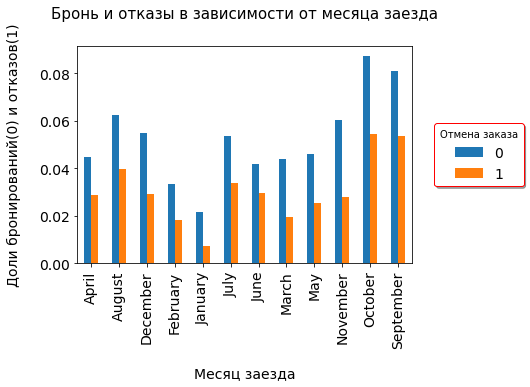

In [14]:
plt_chart(df_train,
         'arrival_date_month',
         'Бронь и отказы в зависимости от месяца заезда',
         'Месяц заезда',
         'Доли бронирований(0) и отказов(1)',
         90)

По графику можно заметить, что количество людей не отказавшихся от брони примерно на 30% больше, чем отказавшихся, и всё же, тенденция из месяц в месяц прослеживается примерно одинаковая по отказам и бронированием номера. И можно обратить внимание, что бронирований и отказов в сентябре и октябре намного больше, чем в другие месяцы.

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


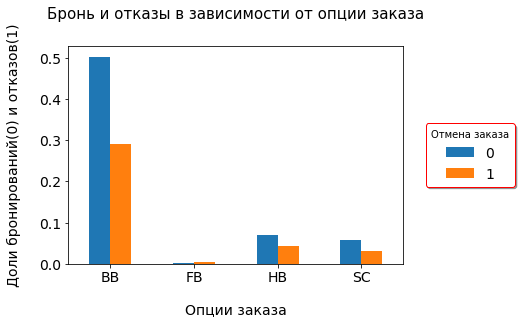

In [15]:
plt_chart(df_train,
         'meal',
         'Бронь и отказы в зависимости от опции заказа',
         'Опции заказа',
         'Доли бронирований(0) и отказов(1)',
         0)

По графику можно сделать вывод, что большая доля людей, пользуется опцией заказа как "ВВ" - включён завтрак. А наименьшее кол-во предпочитает "FB" - включён завтрак, обед и ужин и "SC" - нет дополнительных опций. Доля не отказавшихся от брони, по отношению к отказавшимся примерно 30% и такое примерно во всех опциях заказов.

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


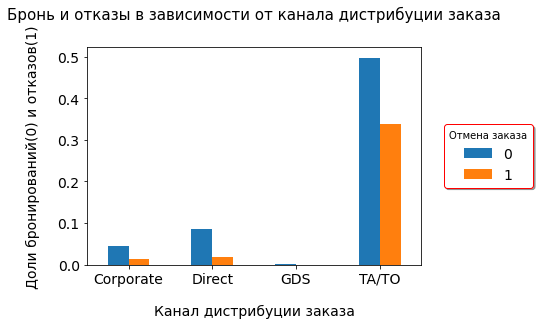

In [16]:
plt_chart(df_train,
         'distribution_channel',
         'Бронь и отказы в зависимости от канала дистрибуции заказа',
         'Канал дистрибуции заказа',
         'Доли бронирований(0) и отказов(1)',
         0)

Из графика особо выделяется канал дистрибуции заказа как "ТА/ТО". Он пользуется особым спросом в отношении брони и отказа от неё. А наименьшим спросов "GDS".

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


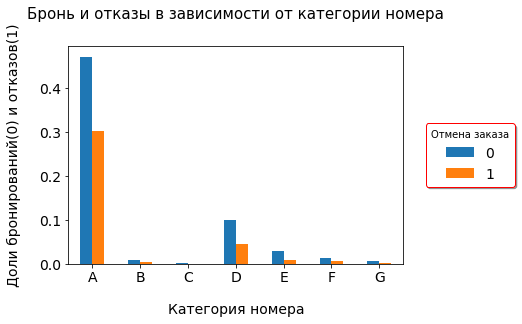

In [17]:
plt_chart(df_train,
         'reserved_room_type',
         'Бронь и отказы в зависимости от категории номера',
         'Категория номера',
         'Доли бронирований(0) и отказов(1)',
         0)

На первом месте по спросу с явным отрывом от остальных категорий принадлежит категории "А". Второе место по спросу у категории "D". Здесь так-же прослеживается интервал между бронью и отказом в 30% по каждому из категорий номера.

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


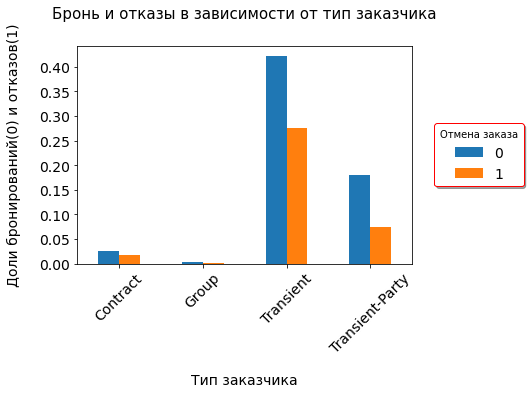

In [18]:
plt_chart(df_train,
         'customer_type',
         'Бронь и отказы в зависимости от тип заказчика',
         'Тип заказчика',
         'Доли бронирований(0) и отказов(1)',
         45)

Большим спросом пользуются типы заказчиков "Transient" и "Transient-party" и естественно, бронь и отказы в такм же соотношении как и везде, примерно 30%. Наименьшим спросом пользуется "Group" заезды.

#### Предобработка категориальных признаков

####  Кодирование  с помощью LabelEncoder

In [19]:
#  Функция для кодировки категориальных признаков с помощью "LabelEncoder()"

def encoding_categ(data_train, data_test, colum):
    my_label = preprocessing.LabelEncoder()  
    data_train[colum]= my_label.fit_transform(data_train[colum]) 
    data_test[colum]= my_label.transform(data_test[colum]) 
    
    return (data_train, data_test)
    

In [20]:
categ_features_train, categ_features_test = encoding_categ(categ_features_train, 
                                                           categ_features_test, 
                                                           'meal')

Вызываем функцию и сохраняем её результат обратно в Data Frame. Применяем к столбцу "meal"

In [21]:
categ_features_test['meal'].value_counts()  #  Проверяем результат кодировки (функции)

0    24684
3     5293
2     2399
1       36
Name: meal, dtype: int64

In [22]:
categ_features_train['meal'].value_counts()  #  Проверяем результат кодировки (функции)

0    51697
2     7292
3     5789
1      451
Name: meal, dtype: int64

In [23]:
categ_features_train, categ_features_test = encoding_categ(categ_features_train, 
                                                           categ_features_test, 
                                                           'distribution_channel')

Вызываем функцию и сохраняем её результат обратно в Data Frame. Применяем к столбцу "distribution_channel"

In [24]:
categ_features_train, categ_features_test = encoding_categ(categ_features_train, 
                                                           categ_features_test, 
                                                           'customer_type')

Вызываем функцию и сохраняем её результат обратно в Data Frame. Применяем к столбцу "customer_type"

In [25]:
categ_features_train, categ_features_test = encoding_categ(categ_features_train, 
                                                           categ_features_test, 
                                                           'arrival_date_month')

Вызываем функцию и сохраняем её результат обратно в Data Frame. Применяем к столбцу "arrival_date_month"

In [26]:
print('+---------------------------------------------------------------------------------------------------------------+')
print()
print('Кодировали столбцы "meal", "distribution_channel", "customer_type" и "arrival_date_month" с помощью LabelEncoder.')
print()
print('+---------------------------------------------------------------------------------------------------------------+')

+---------------------------------------------------------------------------------------------------------------+

Кодировали столбцы "meal", "distribution_channel", "customer_type" и "arrival_date_month" с помощью LabelEncoder.

+---------------------------------------------------------------------------------------------------------------+


####  Кодирование  с помощью pd.get_dummies

In [27]:
categ_features_train = pd.get_dummies(categ_features_train, columns=['reserved_room_type'], drop_first=True)

categ_features_test = pd.get_dummies(categ_features_test, columns=['reserved_room_type'], drop_first=True)

categ_features_test.head(2)  #  Проверяем кодировку признаков

,arrival_date_month,meal,country,distribution_channel,customer_type,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,4,0,PRT,3,2,0,0,0,0,0,0
1,4,0,AUT,3,2,0,0,0,0,0,0


In [28]:
print('+-----------------------------------------------------------------------------------------------------------------+')
print()
print('Кодировал признаки "reserved_room_type" и удалил ненужные признаки во избежания дамми-ловушки.')
print()
print('+-----------------------------------------------------------------------------------------------------------------+')


+-----------------------------------------------------------------------------------------------------------------+

Кодировал признаки "reserved_room_type" и удалил ненужные признаки во избежания дамми-ловушки.

+-----------------------------------------------------------------------------------------------------------------+


####  Кодирование  с помощью OrdinalEncoder

In [29]:
categ_features_train['country'].value_counts()  #  Смотрим на кол-во стран

PRT    28831
FRA     5974
GBR     5109
ESP     4900
DEU     3887
       ...  
STP        1
BFA        1
BHR        1
ATA        1
HND        1
Name: country, Length: 155, dtype: int64

In [30]:
categ_features_test['country'].value_counts()  #  Смотрим на кол-во стран

PRT    9887
GBR    3927
FRA    3477
DEU    2378
ESP    1932
       ... 
IMN       1
SLV       1
NCL       1
ATA       1
FRO       1
Name: country, Length: 143, dtype: int64

In [31]:
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
categ_features_train[['country']] = enc.fit_transform(categ_features_train[['country']])   #  Кодируем признак и обучаем
categ_features_test[['country']] = enc.transform(categ_features_test[['country']])   #  Кодируем признак без обучения

categ_features_test.head(2)  #  Проверяем кодировку

,arrival_date_month,meal,country,distribution_channel,customer_type,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,4,0,117.0,3,2,0,0,0,0,0,0
1,4,0,9.0,3,2,0,0,0,0,0,0


Применил порядковое кодирование с помощью "OrdinalEncoder" для столбца "country" двух Data Frame.

### Предобработка количественных  признаков

**Удаляем ненужные столбцы**

In [32]:
drop_col_df = ['arrival_date_week_number',     # — Неделя заезда.
               'id',                           # — Номер записи.
               'arrival_date_year',            # — Год заезда.
               'arrival_date_day_of_month']    # — День заезда. 

In [33]:
quantit_features_train = quantit_features_train.drop(drop_col_df, 1)
quantit_features_test = quantit_features_test.drop(drop_col_df, 1)

quantit_features_train.head(2)  # Проверяем удалившиеся столбцы

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7.0,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1
1,0,14.0,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2


Удаляем столбцы :

- arrival_date_week_number,   - У нас есть номер недели, поэтому месяц не нужен, лишняя информация.
- id,                         - Бесполезная информация.
- arrival_date_year,          - Бесполезная информация, нет разницы в какой год человек ездил, не повлияет на обучение.
- arrival_date_day_of_month.  - Бесполезная информация, нет разницы в какой день человек ездил, не повлияет на обучение.

Для избежания запоминания моделью не нужных данных.


In [34]:
quantit_features_train.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,0.368609,96.337917,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,0.482431,96.127545,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,17.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,64.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,151.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Обращаем наше внимание, впервую очередь на mean, 50%(медиану) и max, т.к. по этим значениям можно явно увидеть выбросы.

In [35]:
quantit_features_test.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,0.388467,97.587869,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,0.487409,86.507146,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,23.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,76.000000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,155.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Обращаем наше внимание, впервую очередь на mean, 50%(медиану) и max, т.к. по этим значениям можно явно увидеть выбросы.

####  Признак days_in_waiting_list

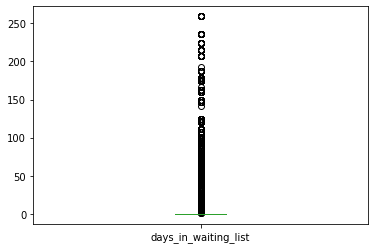

In [36]:
quantit_features_train.days_in_waiting_list.plot.box(return_type='both');

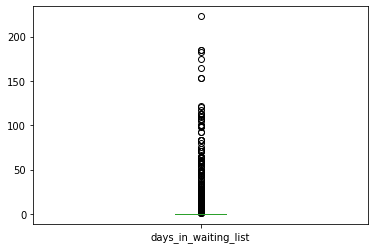

In [37]:
quantit_features_test.days_in_waiting_list.plot.box(return_type='both');

In [38]:
quantit_features_train.days_in_waiting_list.describe()

count    65229.000000
mean         3.334422
std         18.239606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64

In [39]:
quantit_features_test.days_in_waiting_list.describe()

count    32412.000000
mean         0.262341
std          4.733027
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.000000
Name: days_in_waiting_list, dtype: float64

In [40]:
df_train = df_train.loc[df_train['days_in_waiting_list'] < 181]
df_test = df_test.loc[df_test['days_in_waiting_list'] < 181]

####  Признак previous_bookings_not_canceled

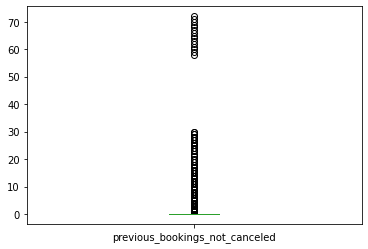

In [41]:
df_test.previous_bookings_not_canceled.plot.box(return_type='both');

In [42]:
df_test.previous_bookings_not_canceled.describe()

count    32408.000000
mean         0.171439
std          1.875285
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         72.000000
Name: previous_bookings_not_canceled, dtype: float64

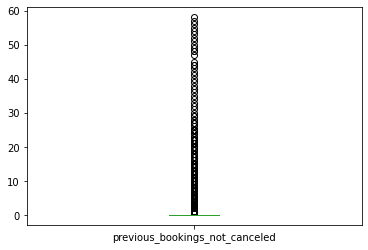

In [43]:
df_train.previous_bookings_not_canceled.plot.box(return_type='both');

In [44]:
df_train.previous_bookings_not_canceled.describe()

count    65092.000000
mean         0.107940
std          1.328024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: previous_bookings_not_canceled, dtype: float64

In [45]:
df_train = df_train.loc[df_train['previous_bookings_not_canceled'] < 36]
df_test = df_test.loc[df_test['previous_bookings_not_canceled'] < 36]

Удалил выбросы в столбце **days_in_waiting_list**, по моему мнению, довольно много дней заказ ожидал подтверждения. Ограничился 180 днями. Так же удалил выбросы в столбце **previous_bookings_not_canceled**. Удалил выбросы в **df_train** и **df_test**.

####  Признак previous_cancellations

In [46]:
df_train['previous_cancellations'].value_counts()

0     59454
1      5367
2        54
3        42
11       35
24       28
25       19
26       18
19       17
13       12
14       11
6         6
4         2
5         2
21        1
Name: previous_cancellations, dtype: int64

In [47]:
df_train = df_train.loc[df_train['previous_cancellations'] < 7]

In [48]:
df_train.previous_cancellations.value_counts()

0    59454
1     5367
2       54
3       42
6        6
4        2
5        2
Name: previous_cancellations, dtype: int64

In [49]:
df_test.previous_cancellations.value_counts()

0    32182
1      165
2       29
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

По выбросам, можно сказать следующее, что в столбце **"previous_cancellations"** есть подозрительные выбросы, удаляем их, т к в **df_test** до 5 отмен, а в **df_train** гораздо больше.

####  Объединение Data Frame

In [50]:
features_train = categ_features_train.join(quantit_features_train, lsuffix = '-REVIEW')

features_test = categ_features_test.join(quantit_features_test, lsuffix = '-REVIEW')

Объединяем Data Frame, для масштабирования.

####  Масштабируем признаки

In [51]:
target_train = features_train['is_canceled']
features_train = features_train.drop('is_canceled', axis=1)

target_test = features_test['is_canceled']
features_test = features_test.drop('is_canceled', axis=1)


num_col = ['lead_time', 
           'stays_in_weekend_nights', 
           'stays_in_week_nights', 
           'adults',
           'children',
           'babies',
           'meal',
           'previous_cancellations',
           'previous_bookings_not_canceled',
           'booking_changes',
           'days_in_waiting_list',
           'required_car_parking_spaces',
           'total_of_special_requests',
           'total_nights',
           'country',
           'distribution_channel',
           'customer_type',
           'arrival_date_month']


scaler = StandardScaler()
scaler.fit(features_train[num_col]) 

features_train[num_col] = scaler.transform(features_train[num_col])
features_test[num_col] = scaler.transform(features_test[num_col])


In [52]:
features_train.head(2)  #  Проверяем масштабирование.

,arrival_date_month,meal,country,distribution_channel,customer_type,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,-0.299861,-0.495243,-0.837925,-1.803871,-0.264527,0,0,0,0,0,...,-0.22406,-0.073248,0,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,-0.681336,-1.179440
1,-0.299861,-0.495243,-0.837925,0.433441,-0.264527,0,0,0,0,0,...,-0.22406,-0.073248,0,-0.133547,-0.081193,-0.327145,-0.182814,-0.244069,0.647419,-0.604097


Разделил df на целевой и остальные признаки. Сделал стандартизацию признаков. Обучил на тренировочной выборке. Переименовал новые названия столбцов, на те, которые были раньше.

In [53]:
target_train.value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

In [54]:
target_test.value_counts()

0    19821
1    12591
Name: is_canceled, dtype: int64

Балансировку классов делать не будем т к разница между классами не большая.

**Вывод**

В данном разделе проверил данные и откорректировал их. Пропуски в данных не обнаружил, зато обнаружил одинаковые строки, решено их оставить. В некоторых признаках были обнаружены выбросы, мы их удалили. Сделал предобработку как обучающего df так и тестового df.

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [55]:
df_before_introduction_deposits = df_test.copy()    # Копируем df для оценки прибыли отеля без внедрения депозитов  test

In [56]:
df_before_introduction_deposits = df_before_introduction_deposits[['arrival_date_month', 'total_nights', 'is_canceled', 'reserved_room_type']]
df_before_introduction_deposits.head(2)

,arrival_date_month,total_nights,is_canceled,reserved_room_type
0,January,1,1,A
1,January,4,1,A


In [57]:
seasonality_coefficient = {'January': 1,    
              'February': 1,   
              'March': 1.2,    
              'April': 1.2,    
              'May': 1.2,      
              'June': 1.4,     
              'July': 1.4,     
              'August': 1.4}  

In [58]:
cost_rooms = {'A': 1000,
               'D': 550,
               'E': 500, 
               'F': 450,
               'B': 800,
               'G': 350, 
               'C': 600}  

In [59]:
room_service = {'A': 400,
               'D': 150,
               'E': 150, 
               'F': 150,
               'B': 350,
               'G': 150, 
               'C': 350}  

Создал три словаря, для заполнение столбцов таблиц.

In [60]:
df_before_introduction_deposits['seasonality_coefficient'] = df_before_introduction_deposits['arrival_date_month'].map(seasonality_coefficient)
df_before_introduction_deposits['cost_rooms'] = df_before_introduction_deposits['reserved_room_type'].map(cost_rooms)
df_before_introduction_deposits['room_service'] = df_before_introduction_deposits['reserved_room_type'].map(room_service)

С помощью функции **map** заполнил столбцы таблицы

In [61]:
df_before_introduction_deposits.loc[df_before_introduction_deposits['total_nights'] == 1, 'number_cleanings'] = 1
df_before_introduction_deposits.loc[df_before_introduction_deposits['total_nights'] == 2, 'number_cleanings'] = 2
df_before_introduction_deposits.loc[df_before_introduction_deposits['total_nights'] > 2, 'number_cleanings'] = np.ceil(df_before_introduction_deposits['total_nights']/2)

Так же заполнил столбцы, исходя из кол-ва ночей в отеле и кол-во уборок.

In [62]:
# Функция для подсчёта затрат, прибыли, выручки без депозита.

def no_deposit_required(data):
    data = (
        data
        .assign(
            expencies = lambda x: x['room_service'] * x['number_cleanings'],  #  Рассчитываем затраты до внедрения депозита (expencies)
            revenue = lambda x: (x['cost_rooms'] * x['total_nights']) * x['seasonality_coefficient'], #  Рассчитываем выручку до внедрения депозита (revenue)                                     
            profit = lambda x: x['revenue'] - x['expencies'])  #  Рассчитываем прибыль до внедрения депозита (profit)
    )
              

    return data



df_before_introduction_deposits = no_deposit_required(df_before_introduction_deposits) #  Сохраняем работу функции в переменную   
  

In [63]:
df_before_introduction_deposits.loc[df_before_introduction_deposits['is_canceled'] == 1, 'expencies'] = df_before_introduction_deposits['room_service'] * 1

In [64]:
df_before_introduction_deposits.loc[df_before_introduction_deposits['is_canceled'] == 1, 'revenue'] = 0
df_before_introduction_deposits.loc[df_before_introduction_deposits['is_canceled'] == 1, 'profit'] = -abs(df_before_introduction_deposits['room_service'] * 1)

In [65]:
df_before_introduction_deposits #  Проверяем рассчеты

,arrival_date_month,total_nights,is_canceled,reserved_room_type,seasonality_coefficient,cost_rooms,room_service,number_cleanings,expencies,revenue,profit
0,January,1,1,A,1.0,1000,400,1.0,400.0,0.0,-400.0
1,January,4,1,A,1.0,1000,400,2.0,400.0,0.0,-400.0
2,January,4,1,A,1.0,1000,400,2.0,400.0,0.0,-400.0
3,January,4,1,A,1.0,1000,400,2.0,400.0,0.0,-400.0
4,January,7,1,A,1.0,1000,400,4.0,400.0,0.0,-400.0
...,...,...,...,...,...,...,...,...,...,...,...
32407,August,6,0,A,1.4,1000,400,3.0,1200.0,8400.0,7200.0
32408,August,7,0,A,1.4,1000,400,4.0,1600.0,9800.0,8200.0
32409,August,7,0,A,1.4,1000,400,4.0,1600.0,9800.0,8200.0
32410,August,7,0,D,1.4,550,150,4.0,600.0,5390.0,4790.0


In [66]:
print('+-----------------------------------------------------------------------------------------+')
print('Выручка до внедрения депозита:', df_before_introduction_deposits['revenue'].sum())
print('+-----------------------------------------------------------------------------------------+')

print('+-----------------------------------------------------------------------------------------+')
print('Затраты до внедрения депозита:', df_before_introduction_deposits['expencies'].sum())
print('+-----------------------------------------------------------------------------------------+')

print('+-----------------------------------------------------------------------------------------+')
print('Прибыль до внедрения депозита:', df_before_introduction_deposits['profit'].sum())
print('+-----------------------------------------------------------------------------------------+')

+-----------------------------------------------------------------------------------------+
Выручка до внедрения депозита: 65230500.0
+-----------------------------------------------------------------------------------------+
+-----------------------------------------------------------------------------------------+
Затраты до внедрения депозита: 17545500.0
+-----------------------------------------------------------------------------------------+
+-----------------------------------------------------------------------------------------+
Прибыль до внедрения депозита: 47685000.0
+-----------------------------------------------------------------------------------------+


**Вывод**

При формулировки ML-задачи на основе бизнес-задачи, мы подсчитали выручку отеля до внедрения модели. Выручка составила 65.230.500 млн.руб.

## Шаг 4. Разработка модели ML

Найдем для модели логистической регресии оптимальный гиперпараметр Сs 

In [67]:
%%time
best_model = None
best_score = 0
best_result = 0

for c in np.arange(1, 10):
    model = LogisticRegressionCV(random_state=69, cv=5, solver="liblinear", Cs=c, scoring='f1')      
    scores = np.mean(cross_val_score(model, features_train, target_train, cv=5))
    
    if scores > best_result:
        best_model = model
        best_score = scores 
        
best_score #  Вывод лучшего результата метрики

CPU times: user 7min 15s, sys: 54.3 s, total: 8min 9s
Wall time: 8min 10s


0.6143247897063773

In [68]:
best_model

LogisticRegressionCV(Cs=9, cv=5, random_state=69, scoring='f1',
                     solver='liblinear')

In [69]:
#  Используем "HalvingRandomSearchCV" - рандомизированный поиск по гиперпараметрам.

param_grid = {"max_depth": range(5, 81),  
              "n_estimators": range(1, 81)  #  Создаем словарь с гиперпараметрами, имя - ключ, а значение - числа для перебора
              }                             
              
                                                      
model = RandomForestClassifier(random_state=69)
search_random = HalvingRandomSearchCV(model, param_grid,           #  Перебираем гиперпараметры и сохраняем в "search_random"
                       random_state=69, cv=5, n_jobs = -1, max_resources = 100, scoring = 'f1').fit(features_train, target_train)


search_random.best_params_  #  Лучшие гиперпараметры

{'n_estimators': 27, 'max_depth': 25}

In [70]:
search_random.best_score_

0.3866666666666666

Результат accuracy на RandomForestClassifier

**Лучшая модель**

In [71]:
model = LogisticRegressionCV(random_state=69, solver='liblinear', Cs=9)   
model.fit(features_train, target_train)
predicted = model.predict(features_test)
f1_score(target_test, predicted)

0.5789115646258504

Метрика f1_score, результат = 0.578.

In [72]:
yes_deposits = df_test.copy()    # Копируем df для оценки прибыли отеля после внедрения депозитов  test

In [73]:
pred = pd.Series(predicted)  #  Сохраняем предсказания в переменную, переделав их в Series.
yes_deposits['is_canceled'] = pred  #  Заменяем столбец "is_canceled" на наши предсказания

In [74]:
yes_deposits['seasonality_coefficient'] = yes_deposits['arrival_date_month'].map(seasonality_coefficient)
yes_deposits['cost_rooms'] = yes_deposits['reserved_room_type'].map(cost_rooms)
yes_deposits['room_service'] = yes_deposits['reserved_room_type'].map(room_service)

Применяем функцию "map" для ранее созданых словарей

In [75]:
yes_deposits.loc[yes_deposits['total_nights'] == 1, 'number_cleanings'] = 1
yes_deposits.loc[yes_deposits['total_nights'] == 2, 'number_cleanings'] = 2
yes_deposits.loc[yes_deposits['total_nights'] > 2, 'number_cleanings'] = np.ceil(yes_deposits['total_nights']/2)

Подсчитываем кол-во уборок

In [76]:
yes_deposits.loc[yes_deposits['is_canceled'] == 1, 'deposit_implementation'] = 0.8  #  С депозитом
yes_deposits.loc[yes_deposits['is_canceled'] == 0, 'deposit_implementation'] = 1  #  Без депозита

Если есть вероятность, что человек откажется от брони, то предлагаем ему внести депозит, если нет, не предлагаем.

In [77]:
yes_deposits.loc[yes_deposits['is_canceled'] == 1, 'deposits'] = ((yes_deposits['total_nights'] 
                                                                  * yes_deposits['cost_rooms']) 
                                                                  * yes_deposits['deposit_implementation'])

yes_deposits.loc[yes_deposits['is_canceled'] == 0, 'deposits'] = 0

Подсчитываем депозит для вероятного отказа, а для вероятного не отказа, ставим значение "0"

In [78]:
yes_deposits['expencies'] = yes_deposits['room_service'] * yes_deposits['number_cleanings']  #  Рассчитываем затраты до внедрения депозита (expencies)

yes_deposits.loc[yes_deposits['is_canceled'] == 1, 'revenue'] = yes_deposits['deposits']  #  Если бронь отменяется, то выручка = депозиту

yes_deposits.loc[yes_deposits['is_canceled'] == 0, 'revenue'] = ((yes_deposits['cost_rooms']  #  Если бронь подтвердилась, то выручка стоимость номера * кол-во ночей и на коэфициент
                                                                * yes_deposits['total_nights'])
                                                                * yes_deposits['seasonality_coefficient'])

yes_deposits['profit'] = yes_deposits['revenue'] - yes_deposits['expencies']  #  Прибыль = выручка - затраты


In [79]:
yes_deposits  #  Проверка вычислений (визуально)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,total_nights,seasonality_coefficient,cost_rooms,room_service,number_cleanings,deposit_implementation,deposits,expencies,revenue,profit
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,1,1.0,1000,400,1.0,0.8,800.0,400.0,800.0,400.0
1,6087,0,62.0,2017,January,1,1,2,2,2.0,...,4,1.0,1000,400,2.0,1.0,0.0,800.0,4000.0,3200.0
2,6088,0,62.0,2017,January,1,1,2,2,2.0,...,4,1.0,1000,400,2.0,1.0,0.0,800.0,4000.0,3200.0
3,6089,0,71.0,2017,January,1,1,2,2,1.0,...,4,1.0,1000,400,2.0,1.0,0.0,800.0,4000.0,3200.0
4,6090,0,172.0,2017,January,1,1,2,5,2.0,...,7,1.0,1000,400,4.0,1.0,0.0,1600.0,7000.0,5400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164.0,2017,August,35,31,2,4,2.0,...,6,1.4,1000,400,3.0,1.0,0.0,1200.0,8400.0,7200.0
32408,97900,0,21.0,2017,August,35,30,2,5,2.0,...,7,1.4,1000,400,4.0,1.0,0.0,1600.0,9800.0,8200.0
32409,97901,0,23.0,2017,August,35,30,2,5,2.0,...,7,1.4,1000,400,4.0,1.0,0.0,1600.0,9800.0,8200.0
32410,97902,0,34.0,2017,August,35,31,2,5,2.0,...,7,1.4,550,150,4.0,1.0,0.0,600.0,5390.0,4790.0


In [80]:
print('+-----------------------------------------------------------------------------------------+')
print('Выручка после внедрения депозита:', yes_deposits['revenue'].sum())
print('+-----------------------------------------------------------------------------------------+')

print('+-----------------------------------------------------------------------------------------+')
print('Затраты после внедрения депозита:', yes_deposits['expencies'].sum())
print('+-----------------------------------------------------------------------------------------+')

print('+-----------------------------------------------------------------------------------------+')
print('Прибыль после внедрения депозита:', yes_deposits['profit'].sum())
print('+-----------------------------------------------------------------------------------------+')

+-----------------------------------------------------------------------------------------+
Выручка после внедрения депозита: 98903370.0
+-----------------------------------------------------------------------------------------+
+-----------------------------------------------------------------------------------------+
Затраты после внедрения депозита: 22343650.0
+-----------------------------------------------------------------------------------------+
+-----------------------------------------------------------------------------------------+
Прибыль после внедрения депозита: 76559720.0
+-----------------------------------------------------------------------------------------+


**Вывод**

Обучил разные модели и оценил их качество кросс-валидацией. Выбрал лучшую модель и проверьте её на тестовой выборке.
Выбрал метрику для обучения. Оценил прибыль, которую принесёт выбранная модель за год.

## Шаг 5. Опишите портрет «ненадёжного» клиента

In [81]:
count_no_deposit = len(yes_deposits[yes_deposits['is_canceled']==0])  # Люди без депозита
count_yes_deposit = len(yes_deposits[yes_deposits['is_canceled']==1])  # Люди с депозитом

pct_of_no_sub = count_no_deposit/(count_no_deposit+count_yes_deposit)
display("Процент человек без депозита", pct_of_no_sub*100)

pct_of_sub = count_yes_deposit/(count_no_deposit+count_yes_deposit)
display("Процент человек с депозитом", pct_of_sub*100)

'Процент человек без депозита'

75.34035131046831

'Процент человек с депозитом'

24.65964868953169

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


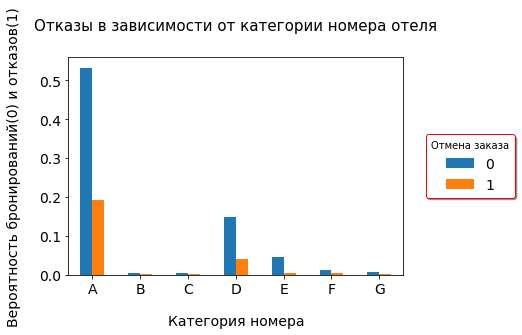

In [82]:
plt_chart(yes_deposits,
         'reserved_room_type',
         'Отказы в зависимости от категории номера отеля',
         'Категория номера',
         'Вероятность бронирований(0) и отказов(1)',
         0)

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


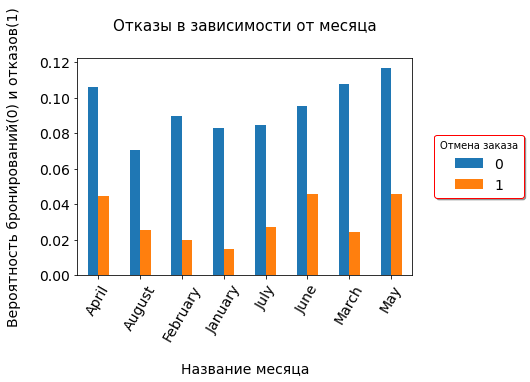

In [83]:
plt_chart(yes_deposits,
         'arrival_date_month',
         'Отказы в зависимости от месяца',
         'Название месяца',
         'Вероятность бронирований(0) и отказов(1)',
         60)

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


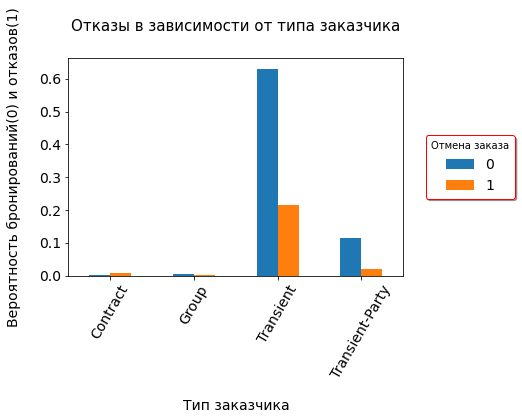

In [84]:
plt_chart(yes_deposits,
         'customer_type',
         'Отказы в зависимости от типа заказчика',
         'Тип заказчика',
         'Вероятность бронирований(0) и отказов(1)',
         60)

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


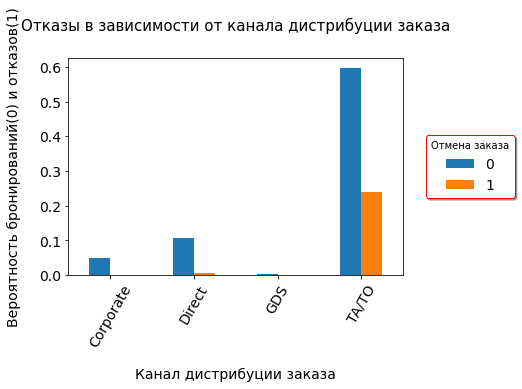

In [85]:
plt_chart(yes_deposits,
         'distribution_channel',
         'Отказы в зависимости от канала дистрибуции заказа',
         'Канал дистрибуции заказа',
         'Вероятность бронирований(0) и отказов(1)',
         60)

/tmp/ipykernel_94/582096889.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


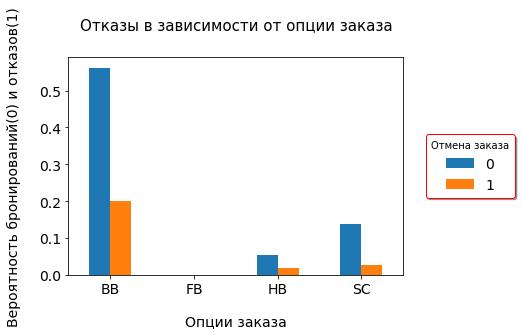

In [86]:
plt_chart(yes_deposits,
         'meal',
         'Отказы в зависимости от опции заказа',
         'Опции заказа',
         'Вероятность бронирований(0) и отказов(1)',
         360)

**Вывод**

Клиент, который склонен к отказу от брони, имеет следующие признаки:

- Если брать во внимание категорию номера, то вероятность отказов больше всего в категории "А" и "D", при этом, наименьшее число вероятных отказов в остальных категориях очень низкая.
- Есть определенные изменения по вероятным отказам в зависимости от месяца, самое большое количество в июне, мае, апреле и в июле, в остальные месяцы наименее вероятны отказы от брони.
- Лидирующую позицию по возможным отказам занимает тип заказчика "Transient" — не связано с договором или групповым заездом, остальные заказчики, имеют маловероятный отказ и заслуживают большего доверия.
- Большое количество вероятных отказов в канале дистрибуции заказа занимает "ТА/ТО", а в остальных канал минимальная вероятность отказа.
- Не мало влияет и опции заказа, самое большое количество вероятных отказов у категории "ВВ" — включён завтрак и "SC" — без дополнительных опций, большее доверие следует уделить категории "FB".
 


Анализ был сделан на основе категориальных признаков, не беря во внимание количественные признаки, дабы не плодить множество графиков.

## Шаг 6. Напишите общий вывод

В данном проекте, мы исследовали внедрение депозита для клиентов, которые подвержены отмене брони. Сначала, изучили Data Frame в нем есть типы данных int64, float64, object(для обучения требуется последующая их обработка), обработали его удалив выбросы, почистив его от бробелов и всего такого, так же удалили ненужные столбцы, которые могли ввести алгоритм обучения по ложному следу, далее кодировали(типы данных object) и масштабировали признаки и переименовали столбцы.  Дальше, мы перешли к подсчету выручки, затратов и прибыли, до внедрения депозита. 

- Выручка до внедрения депозита: 65.230.500 млн.руб
- Затраты до внедрения депозита: 17.545.500 млн.руб
- Прибыль до внедрения депозита: 47.685.000 млн.руб

Далее произвели обучение модели LogisticRegressionCV и RandomForestClassifier, выбрали лучшую модель(LogisticRegressionCV) и сделали итоговое предсказание. После рассчитали прибыль после внедрения депозитов, она выросла 

- Выручка после внедрения депозита: 98.903.370 млн.руб.
- Затраты после внедрения депозита: 22.343.650 млн.руб.
- Прибыль после внедрения депозита: 76.559.720 млн.руб.